# Data Introduction

In [172]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset grape_quality.csv
df = pd.read_csv('../datas/grape_quality.csv')

# Tampilkan beberapa baris awal dataset
print("Contoh data:")
display(df.head())
print("\nDimensi dataset:")
display(df.shape)

Contoh data:


,sample_id,variety,region,quality_score,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,harvest_date,sun_exposure_hours,soil_moisture_percent,rainfall_mm
0,1,Riesling,Barossa Valley,2.11,13.70,3.17,251.81,18.58,9/4/2023,8.4,55.9,223.3
1,2,Pinot Noir,Loire Valley,2.83,20.84,3.15,289.00,22.08,9/16/2023,8.8,36.9,312.1
2,3,Sauvignon Blanc,Napa Valley,3.52,27.46,4.07,125.14,21.40,8/25/2023,11.1,64.9,698.7
3,4,Riesling,Napa Valley,2.28,24.64,3.15,237.46,12.31,9/13/2023,8.0,54.5,660.1
4,5,Merlot,Napa Valley,2.90,26.13,3.18,221.52,12.24,8/11/2023,11.2,36.3,410.4



Dimensi dataset:


(1000, 12)

# Data Preparation

In [173]:
# Pembersihan dan transformasi data

# Konversi tanggal panen ke tipe datetime dan ekstrak bulan
df['harvest_date'] = pd.to_datetime(df['harvest_date'])
df['harvest_month'] = df['harvest_date'].dt.month

# Cek nilai kosong (missing values)
print("\nJumlah nilai kosong tiap kolom:")
display(df.isna().sum())

# Isi nilai kosong dengan rata-rata kolom (mean imputation) untuk kolom numeric
# Gunakan assignment langsung untuk menghindari FutureWarning pandas 3.0+
df['acidity_ph'] = df['acidity_ph'].fillna(df['acidity_ph'].mean())
df['soil_moisture_percent'] = df['soil_moisture_percent'].fillna(df['soil_moisture_percent'].mean())

# Buat target klasifikasi: kualitas tinggi (1) vs rendah (0) berdasarkan ambang 2.5
df['quality_class'] = (df['quality_score'] >= 2.5).astype(int)
print("\nDistribusi kelas target kualitas:")
df['quality_class'].value_counts()


Jumlah nilai kosong tiap kolom:


sample_id                0
variety                  0
region                   0
quality_score            0
sugar_content_brix       0
acidity_ph               5
cluster_weight_g         0
berry_size_mm            0
harvest_date             0
sun_exposure_hours       0
soil_moisture_percent    5
rainfall_mm              0
harvest_month            0
dtype: int64


Distribusi kelas target kualitas:


quality_class
1    506
0    494
Name: count, dtype: int64

# Data Exploration

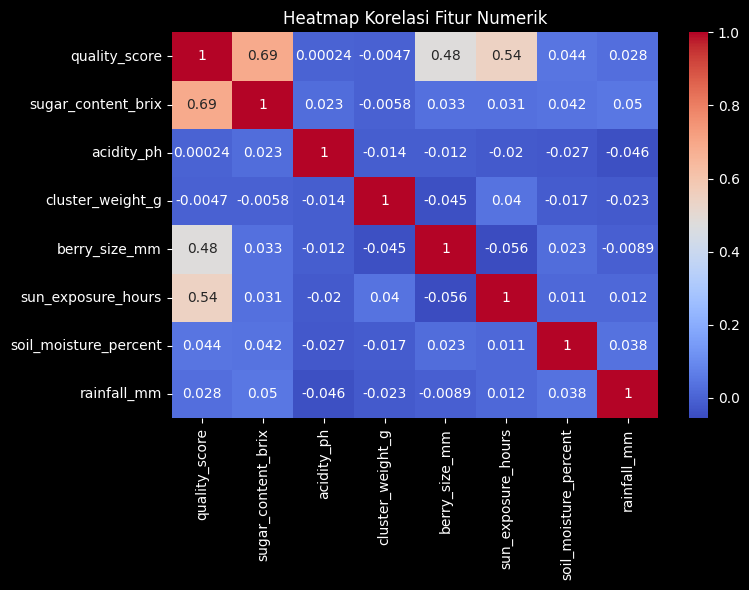

In [174]:
# Eksplorasi data: melihat korelasi antar fitur numerik
numeric_cols = [
    'quality_score', 'sugar_content_brix', 'acidity_ph', 'cluster_weight_g', 
    'berry_size_mm', 'sun_exposure_hours', 'soil_moisture_percent', 'rainfall_mm'
]
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()

# 1. Chi-Square Test (Filter-based)


Hasil Chi-Square (fitur teratas):


,Feature,Chi2,p_value
0,variety_Syrah,4.146285,0.041726
1,variety_Pinot Noir,2.672587,0.102090
2,region_Rioja,2.308675,0.128654
3,region_Loire Valley,1.449210,0.228655
4,variety_Cabernet Sauvignon,0.844296,0.358171


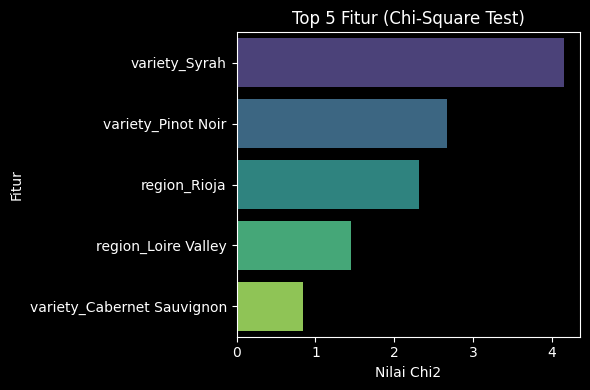

In [175]:
# Siapkan matriks fitur kategorikal (one-hot) dan target
X_chi = pd.get_dummies(df[['variety', 'region', 'harvest_month']], drop_first=False)
y = df['quality_class']

# Hitung statistik Chi-Square dan p-value untuk tiap fitur
chi_scores, p_values = chi2(X_chi, y)
chi_df = pd.DataFrame({
    'Feature': X_chi.columns,
    'Chi2': chi_scores,
    'p_value': p_values
})
chi_df = chi_df.sort_values('Chi2', ascending=False).reset_index(drop=True)
print("\nHasil Chi-Square (fitur teratas):")
display(chi_df.head(5))

# Visualisasi hasil Chi-Square untuk fitur teratas
top_chi = chi_df.head(5)
plt.figure(figsize=(6,4))
sns.barplot(x='Chi2', y='Feature', hue='Feature', data=top_chi, palette='viridis', legend=False)
plt.title("Top 5 Fitur (Chi-Square Test)")
plt.xlabel("Nilai Chi2")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

# 2. Forward Selection (Wrapper-based)


Fitur terpilih oleh Forward Selection:


['sugar_content_brix',
 'berry_size_mm',
 'sun_exposure_hours',
 'variety_Riesling',
 'variety_Sauvignon Blanc']

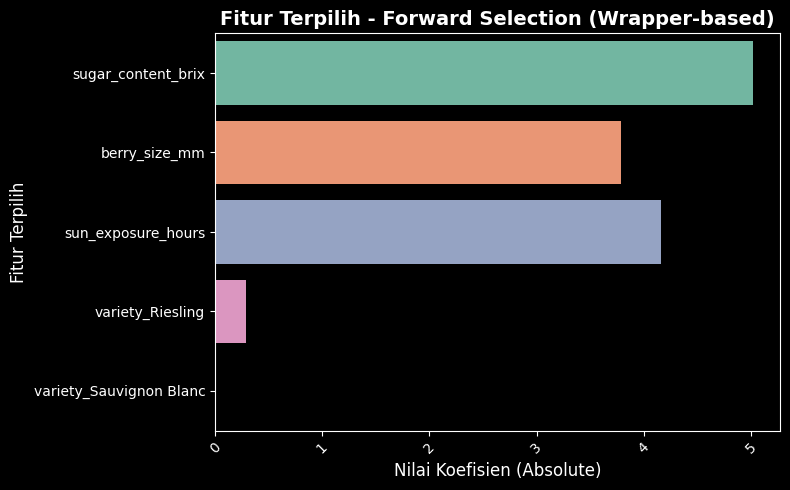


Jumlah fitur terpilih: 5 dari 24 fitur total


In [176]:
# Siapkan fitur: gabungkan numerik dan kategorikal (one-hot)
features = ['variety','region','harvest_month','sugar_content_brix','acidity_ph',
            'cluster_weight_g','berry_size_mm','sun_exposure_hours','soil_moisture_percent','rainfall_mm']
X = pd.get_dummies(df[features], drop_first=False)
y = df['quality_class']

# Skalakan data untuk meningkatkan konvergensi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Inisialisasi model klasifikasi (Logistic Regression) dengan parameter yang lebih baik
logreg = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

# Terapkan Sequential Feature Selector dengan arah maju (forward)
sfs = SequentialFeatureSelector(logreg, n_features_to_select=5, direction='forward', 
                                scoring='accuracy', cv=5)
sfs.fit(X_scaled, y)

# Fitur yang terpilih
selected_mask = sfs.get_support()
selected_features = X.columns[selected_mask]
print("\nFitur terpilih oleh Forward Selection:")
display(list(selected_features))

# Visualisasi fitur terpilih
# Train model dengan fitur terpilih untuk mendapatkan koefisien
logreg_viz = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
logreg_viz.fit(X_scaled[:, selected_mask], y)

plt.figure(figsize=(8,5))
coefficients = abs(logreg_viz.coef_[0])
sns.barplot(x=coefficients, y=list(selected_features), hue=list(selected_features), palette='Set2', legend=False)
plt.title("Fitur Terpilih - Forward Selection (Wrapper-based)", fontsize=14, fontweight='bold')
plt.xlabel("Nilai Koefisien (Absolute)", fontsize=12)
plt.ylabel("Fitur Terpilih", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nJumlah fitur terpilih: {len(selected_features)} dari {X.shape[1]} fitur total")

In [177]:
# Evaluasi model dengan fitur terpilih vs semua fitur
score_selected = cross_val_score(logreg, X[selected_features], y, cv=5).mean()
score_all = cross_val_score(logreg, X, y, cv=5).mean()
print(f"Akurasi CV (5-fold) dengan fitur terpilih: {score_selected:.3f}")
print(f"Akurasi CV (5-fold) dengan semua fitur : {score_all:.3f}")

Akurasi CV (5-fold) dengan fitur terpilih: 0.944
Akurasi CV (5-fold) dengan semua fitur : 0.895


# 3. Random Forest Importance (Embedded)


Top 10 fitur menurut Random Forest Importance:


sugar_content_brix    0.314799
sun_exposure_hours    0.192691
berry_size_mm         0.184503
rainfall_mm           0.054285
cluster_weight_g      0.053403
dtype: float64

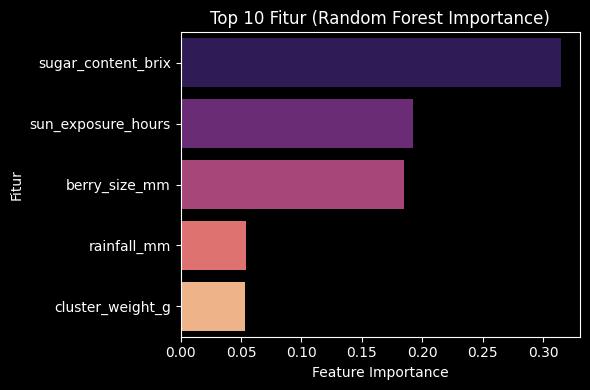

Akurasi CV (5-fold) Random Forest:


np.float64(0.9490000000000001)

In [178]:
# Gunakan Random Forest untuk klasifikasi dan ambil feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
top_importances = importances.head(5)

print("\nTop 10 fitur menurut Random Forest Importance:")
display(top_importances)

# Visualisasi
plt.figure(figsize=(6,4))
sns.barplot(x=top_importances.values, y=top_importances.index, hue=top_importances.index, palette='magma', legend=False)
plt.title("Top 10 Fitur (Random Forest Importance)")
plt.xlabel("Feature Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

# Evaluasi akurasi Random Forest
score_rf = cross_val_score(rf, X, y, cv=5).mean()
print("Akurasi CV (5-fold) Random Forest:")
display(score_rf)